In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
import pandas_ta as ta
import tensorly as tl
from tensorly.decomposition import Tucker
tl.set_backend('pytorch')
import torch
from portfolio_env_with_tcost import AbstractPortfolioEnvWithTCost
from typing import Tuple, Optional
import numpy.typing as npt
import random
import matplotlib.pyplot as plt

In [2]:
class MPTWithTCost(AbstractPortfolioEnvWithTCost):

    def get_obs_space(self) -> gym.spaces.Box:
        self.state_shape = (1, 1, 28, self.universe_size)
        self.t = 0
        self.get_indicators()
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=self.state_shape, dtype=np.float64)
    
    def get_data(self) -> Tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()

        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2010) & (df.date.dt.year <= 2019)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df

        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()

        return len(self.times)-28-1, len(self.tickers)

    def get_indicators(self):
        self.conv3d = torch.nn.Conv3d(in_channels=4, out_channels=32, kernel_size=(1, 3, 1), padding="same").to('cuda')
        self.relu = torch.nn.ReLU()
        self.tucker = Tucker(rank=self.state_shape, init="random")
        self.m = 28
        self.w1, self.w2, self.w3 = 28, 14, 9
        
        df = (pd.DataFrame(self.stock_df, columns=self.tickers))
        df = df.dropna()
        mp = {ticker: pd.DataFrame(df[ticker]).rename(columns={ticker: "close"}) for ticker in self.tickers}
        # SMA df
        sma = {ticker: pd.DataFrame(mp[ticker].ta.sma(self.w1)).rename(columns={"SMA_28": ticker}) for ticker in self.tickers}
        sma_df = pd.concat(sma.values(), axis=1).fillna(0)
        # RSI df
        rsi = {ticker: pd.DataFrame(mp[ticker].ta.rsi(self.w2)).rename(columns={"RSI_14": ticker}) for ticker in self.tickers}
        rsi_df = pd.concat(rsi.values(), axis=1).fillna(0)
        # MACD df
        macd = {ticker: pd.DataFrame(mp[ticker].ta.macd(self.w3, 26, 12)["MACD_9_26_12"]).rename(columns={"MACD_9_26_12": ticker}) for ticker in self.tickers}
        macd_df = pd.concat(macd.values(), axis=1).fillna(0)

        # Compute F = V @ Corr
        V = np.array([np.array(x.T) for x in [df, sma_df, rsi_df, macd_df]])
        Corr = np.array([np.corrcoef(x) for x in V])
        self.F = torch.from_numpy(np.einsum('aki,akj->akij', V, Corr)).to('cuda').float()


    def get_state(self) -> npt.NDArray[np.float64]:
        f = self.F[:, :, self.t + 28 - self.m : self.t + 28, :].clone().detach()      
        f = torch.unsqueeze(f, dim=0) 
        f = self.conv3d(f)
        f = self.relu(f)
        f = torch.squeeze(f, dim=0)
        f = f.cpu()
        core, _ = self.tucker.fit_transform(f)
        return core.detach().numpy()

    def get_prices(self) -> npt.NDArray[np.float64]:
        return np.append(self.stock_df.loc[self.times[self.t+28], :].to_numpy().flatten(), 1.0)
    

In [3]:
env = MPTWithTCost()

In [4]:
from sbx import PPO, DDPG
from stable_baselines3.common.env_util import make_vec_env

In [5]:
# Parallel environments
vec_env = make_vec_env(MPTWithTCost, n_envs=3, env_kwargs={
    'cp': 0.10/365, 
    'cs': 0.10/365
})

# Set seeds
random.seed(42)
np.random.seed(42)
vec_env.seed(42)
vec_env.action_space.seed(42)
torch.manual_seed(42)

model = DDPG("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100_000)
model.save("mpt_with_tcost_model")

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49e+03 |
|    ep_rew_mean     | 5.3e+03  |
| time/              |          |
|    episodes        | 4        |
|    fps             | 7        |
|    time_elapsed    | 1889     |
|    total_timesteps | 14916    |
| train/             |          |
|    actor_loss      | 283      |
|    critic_loss     | 28.8     |
|    n_updates       | 4938     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.49e+03 |
|    ep_rew_mean     | 5.92e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 7        |
|    time_elapsed    | 3059     |
|    total_timesteps | 22374    |
| train/             |          |
|    actor_loss      | 245      |
|    critic_loss     | 4.58e+03 |
|    n_updates       | 7424     |
---------------------------------
------------------------------

In [6]:
class MPTWithTCost(AbstractPortfolioEnvWithTCost):

    def get_obs_space(self) -> gym.spaces.Box:
        self.state_shape = (1, 1, 28, self.universe_size)
        self.t = 0
        self.get_indicators()
        return gym.spaces.Box(low=-np.inf, high=np.inf, shape=self.state_shape, dtype=np.float64)
    
    def get_data(self) -> Tuple[int, int]:
        # read SNP data
        df = pd.read_csv('crsp_snp100_2010_to_2024.csv', dtype='string')
    
        # convert datatypes
        df = df[['date', 'TICKER', 'PRC', 'VOL', 'ASKHI', 'BIDLO', 'FACPR']]
        df.date = pd.to_datetime(df.date)
        df.FACPR = df.FACPR.fillna('0.0')
        df.astype({
            'PRC': float,
            'VOL': float,
            'ASKHI': float,
            'BIDLO': float,
            'FACPR': float
        })
    
        # drop duplicates and nans
        df = df.drop_duplicates(subset=['date', 'TICKER'])
        df.dropna(inplace=True)
    
        # only include stocks that are present in all dates
        ticker_ok = df.TICKER.value_counts() == df.TICKER.value_counts().max()

        def is_max_val_count(ticker: str) -> bool:
          return ticker_ok[ticker]
        
        ok = df.apply(lambda row: is_max_val_count(row['TICKER']), axis=1)
        df = df[ok]
        df = df[(df.date.dt.year >= 2020) & (df.date.dt.year <= 2024)]
    
        # create stock array
        self.stock_df = df.pivot(index='date', columns='TICKER', values='PRC').astype(float)
        
        idx_df = pd.read_csv('crsp_snpidx_2010_to_2024.csv', dtype={
          'DATE': 'string',
          'vwretd': float
        })
        idx_df.DATE = pd.to_datetime(idx_df.DATE)
        idx_df['vol_20'] = idx_df.vwretd.rolling(20).std()
        idx_df['vol_60'] = idx_df.vwretd.rolling(60).std()
        idx_df.set_index('DATE', inplace=True)
        self.idx_df = idx_df

        # adjust for stock splits
        facpr_df = df.pivot(index='date', columns='TICKER', values='FACPR').astype(float)
        self.stock_df = self.stock_df * (1+facpr_df).cumprod(axis=0)
        self.ret = np.log(self.stock_df.pct_change().iloc[1:, :] + 1)
        self.times = df.date.unique()[1:]
        self.tickers = df.TICKER.unique()

        return len(self.times)-28-1, len(self.tickers)

    def get_indicators(self):
        self.conv3d = torch.nn.Conv3d(in_channels=4, out_channels=32, kernel_size=(1, 3, 1), padding="same").to('cuda')
        self.relu = torch.nn.ReLU()
        self.tucker = Tucker(rank=self.state_shape, init="random")
        self.m = 28
        self.w1, self.w2, self.w3 = 28, 14, 9
        
        df = (pd.DataFrame(self.stock_df, columns=self.tickers))
        df = df.dropna()
        mp = {ticker: pd.DataFrame(df[ticker]).rename(columns={ticker: "close"}) for ticker in self.tickers}
        # SMA df
        sma = {ticker: pd.DataFrame(mp[ticker].ta.sma(self.w1)).rename(columns={"SMA_28": ticker}) for ticker in self.tickers}
        sma_df = pd.concat(sma.values(), axis=1).fillna(0)
        # RSI df
        rsi = {ticker: pd.DataFrame(mp[ticker].ta.rsi(self.w2)).rename(columns={"RSI_14": ticker}) for ticker in self.tickers}
        rsi_df = pd.concat(rsi.values(), axis=1).fillna(0)
        # MACD df
        macd = {ticker: pd.DataFrame(mp[ticker].ta.macd(self.w3, 26, 12)["MACD_9_26_12"]).rename(columns={"MACD_9_26_12": ticker}) for ticker in self.tickers}
        macd_df = pd.concat(macd.values(), axis=1).fillna(0)

        # Compute F = V @ Corr
        V = np.array([np.array(x.T) for x in [df, sma_df, rsi_df, macd_df]])
        Corr = np.array([np.corrcoef(x) for x in V])
        self.F = torch.from_numpy(np.einsum('aki,akj->akij', V, Corr)).to('cuda').float()


    def get_state(self) -> npt.NDArray[np.float64]:
        f = self.F[:, :, self.t + 28 - self.m : self.t + 28, :].clone().detach()      
        f = torch.unsqueeze(f, dim=0) 
        f = self.conv3d(f)
        f = self.relu(f)
        f = torch.squeeze(f, dim=0)
        f = f.cpu()
        core, _ = self.tucker.fit_transform(f)
        return core.detach().numpy()

    def get_prices(self) -> npt.NDArray[np.float64]:
        return np.append(self.stock_df.loc[self.times[self.t+28], :].to_numpy().flatten(), 1.0)
    

In [7]:
env = MPTWithTCost(cp=0.10/365, cs=0.10/365)
obs, _ = env.reset()

port_val = [1.0]
snp_val = [1.0]
actions = []
ys = []
times_arr = [env.times[env.t+28]]
mus = []

for i in range(900):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    obs, rewards, terminated, truncated, info = env.step(action)
    ys.append(env.y)
    mus.append(env.mu)
    times_arr.append(env.times[env.t+28])
    port_val.append(info['port_val'])
    snp_val.append(snp_val[-1] * (1 + env.idx_df[env.idx_df.index == env.times[env.t+28]].vwretd.values[0]))
    if terminated:
        break

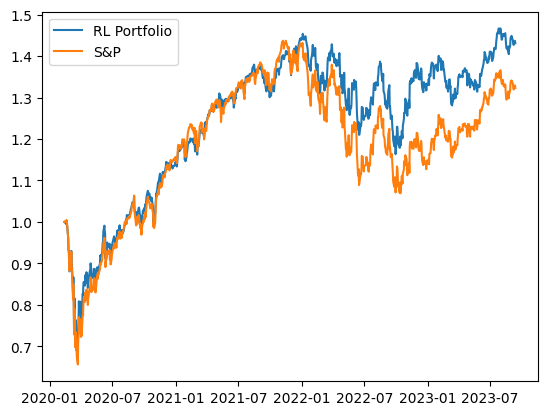

In [8]:
plt.plot(times_arr, np.array(port_val), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()

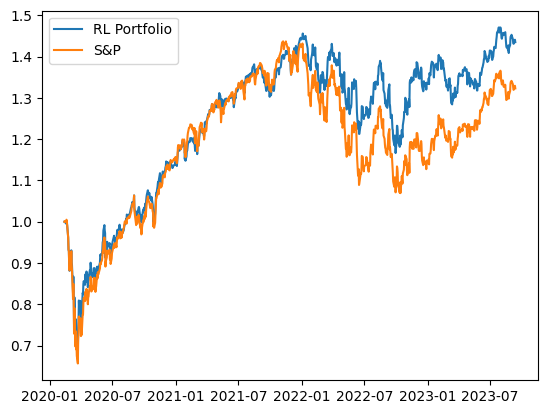

In [9]:
plt.plot(times_arr, np.array(port_val) / np.array([1, *mus]).cumprod(), label='RL Portfolio')
plt.plot(times_arr, np.array(snp_val), label='S&P')
# plt.yscale('log')
plt.legend()
plt.show()